# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск

- стохастический градиентный спуск

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [ ]:
from sklearn.base import BaseEstimator
import warnings
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc,make_scorer

from sklearn.model_selection import KFold, cross_val_score
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
pd.set_option('display.float_format','{:.4f}'.format)

In [ ]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: Вид градиентного спуска ('full' или 'stochastic').

          tolerance: Порог для остановки градиетного спуска.

          max_iter: Максимальное количество шагов в градиентном спуске.

          eta: Скорость обучения (learning rate).

          w0: Массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: Данные на обучение.

          y: Целевая переменная.

        Возвращает:
          self: Обученный регрессор.
        """

        self.loss_history = np.array([])
        if self.gd_type == 'full':
          self.w = self.w0 - self.eta * self.calc_gradient(X, y)
          w_previous_iter = self.w0
          for i in range(self.max_iter):

            if np.linalg.norm(self.w - w_previous_iter) > self.tolerance or i < self.max_iter:

              w_previous_iter = self.w

              self.w = self.w - self.eta * self.calc_gradient(X, y)
              loss_func = self.calc_loss(X, y)
              self.loss_history = np.append(self.loss_history,loss_func)
            else:
              break
          return self
        elif self.gd_type == 'stochastic':
          example_index = 0
          training_example_X = X[example_index]
          training_example_y = y[example_index]
          self.w = self.w0 - self.eta * self.calc_gradient(training_example_X, training_example_y)
          w_previous_iter = self.w0
          for i in range(self.max_iter):
            if np.linalg.norm(self.w - w_previous_iter) > self.tolerance or i < self.max_iter:
              w_previous_iter = self.w
              if example_index == X.shape[0]:
                example_index = 0
              else:
                example_index += 1
              training_example_X = X[example_index]
              training_example_y = y[example_index]
              # print(training_example_y)
              self.w = self.w - self.eta * self.calc_gradient(training_example_X, training_example_y)
              loss_func = self.calc_loss(X, y)
              self.loss_history = np.append(self.loss_history,loss_func)
            else:
              break
          return self
    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: Массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        else:
          prob_positive = self.sigmoid(np.sum(self.w * X, axis = 1))
          prob_negative = 1 - prob_positive
          arr = np.column_stack([prob_positive,prob_negative])
          return arr


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: Массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        else:
            probs = self.predict_proba(X)
            y_pred = np.where(probs[:,0] < 0.5, 0, 1)
            return y_pred


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: Массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: Массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        #print(np.sum(self.w * X, axis = 1))
        if self.gd_type == 'full':
          n = X.shape[0]
          if self.w is None:
            a = self.sigmoid(res = np.sum(self.w0 * X, axis = 1))# вернет массив размером (n,)
            grad_w = np.dot(X.T,a - y)/n
            #grad_w =
            #print(grad_w)
            return grad_w
          else:
            a = self.sigmoid(np.sum(self.w * X, axis = 1))# вернет массив размером (n,)
            grad_w = np.dot(X.T,a - y)/n
            #grad_w = X.T @ (1/(1+np.exp(-X @ self.w)) - y)/n
            #print(grad_w)
            return grad_w
        elif self.gd_type == 'stochastic':
          if self.w is None:
            a = self.sigmoid(np.sum(self.w0 * X))
            grad_w = X * (a - y)
            return grad_w
          else:
            a = self.sigmoid(np.sum(self.w * X))
            grad_w = X * (a - y)
            return grad_w


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: Массив размером (n, d).
          y: Массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # здесь ситуация когда классы обозначаются как 0 и 1, соответственно Logistic Loss будет(если full):
        n = X.shape[0]
        loss = -(1/n) *np.sum(y * np.log(self.sigmoid(res = np.sum(self.w * X, axis = 1)) + 1e-10) + (1 - y)*np.log(1 - self.sigmoid(res = np.sum(self.w * X, axis = 1)) + 1e-10))
        # else:
        #   loss = -(y * np.log(self.sigmoid(np.sum(self.w * X))) + (1 - y) * np.log(1 - self.sigmoid(np.sum(self.w * X))))
        return loss
    def sigmoid(self,res : np.array) ->np.array:
      return 1 / (1 + np.exp(-res))

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

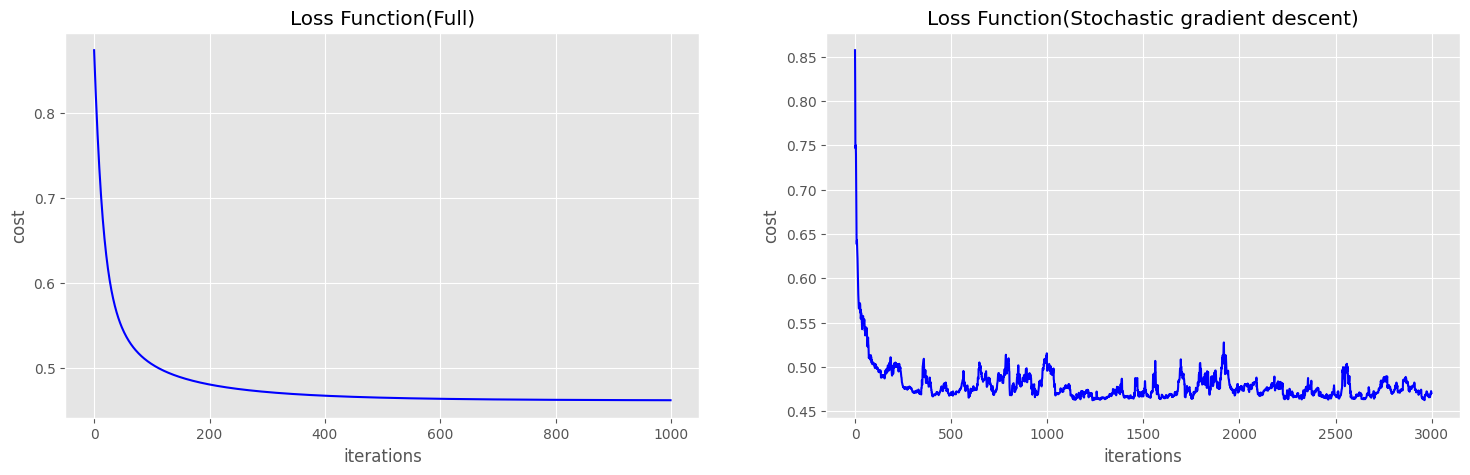

In [ ]:
iter_count = 1000
mlr = MyLogisticRegression(w0 = np.full(X_train.shape[1],1/X_train.shape[1]),
                           max_iter = iter_count,
                           eta = 1e-2,
                           gd_type = 'full')
mlr.fit(X_train, y_train)
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2, figsize = (18,5))
costs_full = mlr.loss_history
iter_arr = np.arange(0, iter_count)
axes[0].plot(iter_arr, costs_full, color = 'blue')
axes[0].set_title('Loss Function(Full)')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('cost');

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_sgd = scaler.fit_transform(X_train)
iter_count = 3000
mlr_sgd = MyLogisticRegression(w0 = np.full(X_train_sgd.shape[1],1/X_train_sgd.shape[1]),
                           max_iter = iter_count,
                           eta = 1e-2,
                           gd_type = 'stochastic')
mlr_sgd.fit(X_train, y_train)
costs_sgd = mlr_sgd.loss_history
iter_arr = np.arange(0, iter_count)
axes[1].plot(iter_arr, costs_sgd, color = 'blue')
axes[1].set_title('Loss Function(Stochastic gradient descent)')
axes[1].set_xlabel('iterations')
axes[1].set_ylabel('cost');

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

roc_auc_score 0.8
auc_precision_recall 0.8


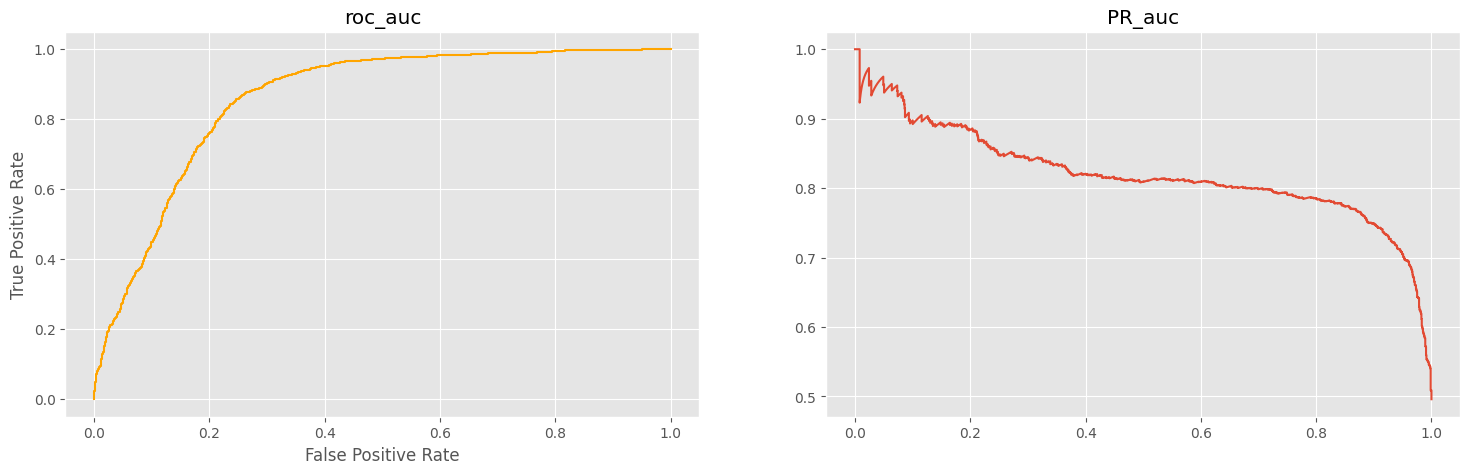

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
y_proba = mlr.predict_proba(X_test)[:,0]
y_pred = mlr.predict(X_test)
print(f"roc_auc_score {roc_auc_score(y_test,y_pred):0.1f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
auc_precision_recall = auc(recall, precision)
print(f"auc_precision_recall {auc_precision_recall:0.1f}")

fpr, tpr, _ = roc_curve(y_test,  y_proba)

fig, axes = plt.subplots(1, 2, figsize = (18,5))
axes[0].plot(fpr,tpr, color = 'orange')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_title('roc_auc');


axes[1].plot(recall, precision)
axes[1].set_title('PR_auc');


**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс валидации.  

In [ ]:
# с roc-auc получилось использовать cross_val_score, pr-auc нет:(
X, y = make_classification(
  n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
  random_state=999)
roc_auc_scores = cross_val_score(mlr, X, y, cv=KFold(n_splits=5), scoring=make_scorer(roc_auc_score))
cv = KFold(n_splits = 5 ,shuffle=True, random_state = 999)
aucs = []

for train, test in cv.split(X, y):
  y_proba = mlr.fit(X[train], y[train]).predict_proba(X[test])[:,0]
  precision, recall, thresholds = precision_recall_curve(y[test], y_proba)
  auc_precision_recall = auc(recall, precision)
  pr_auc = auc(recall, precision)
  aucs.append(pr_auc)

print(f"Оценка на кросс-валидации ROC-AUC:{np.mean(roc_auc_scores):0.2f}")
print(f"Оценка на кросс-валидации PR-AUC:{np.mean(aucs):0.2f}")

Оценка на кросс-валидации ROC-AUC:0.79
Оценка на кросс-валидации PR-AUC:0.83


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [ ]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [ ]:
# `load_boston` has been removed from scikit-learn since version 1.2.

# from sklearn.datasets import load_boston
# boston = load_boston()
# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
# data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# target = raw_df.values[1::2, 2]
# raw_df

In [ ]:
#!wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
#data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [ ]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    n = R.shape[0]
    target_name = R.columns[-1]
    y = R[target_name]
    impurity_criterion = (1 / n) * np.sum((y - (1/n) * np.sum(y))**2)
    return impurity_criterion


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    R_l = R_m[R_m[feature] < t]
    R_r = R_m[R_m[feature] >= t]
    return [R_l,R_r]

def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    R_l = split_node(R_m,feature,t)[0]
    R_r = split_node(R_m,feature,t)[1]
    try:
      q_error = H(R_m) - (R_l.shape[0] / R_m.shape[0]) * H(R_l) - (R_r.shape[0] / R_m.shape[0])* H(R_r)
      return q_error
    except:
      return np.nan


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

In [ ]:
features = X_train.columns[:13]
errors_data = dict()
for feature in features:
  is_first = True
  X_train = X_train.sort_values(feature)
  for element in X_train[feature]:

    error = q_error(X_train,feature, t = element)
    if is_first:
      errors_thresholds = np.array([[error,element]], ndmin=2)
      is_first = False
    else:
      errors_thresholds = np.append(errors_thresholds,[[error,element]], axis = 0)
  errors_data[feature] = errors_thresholds

errors_data.pop('ZN');


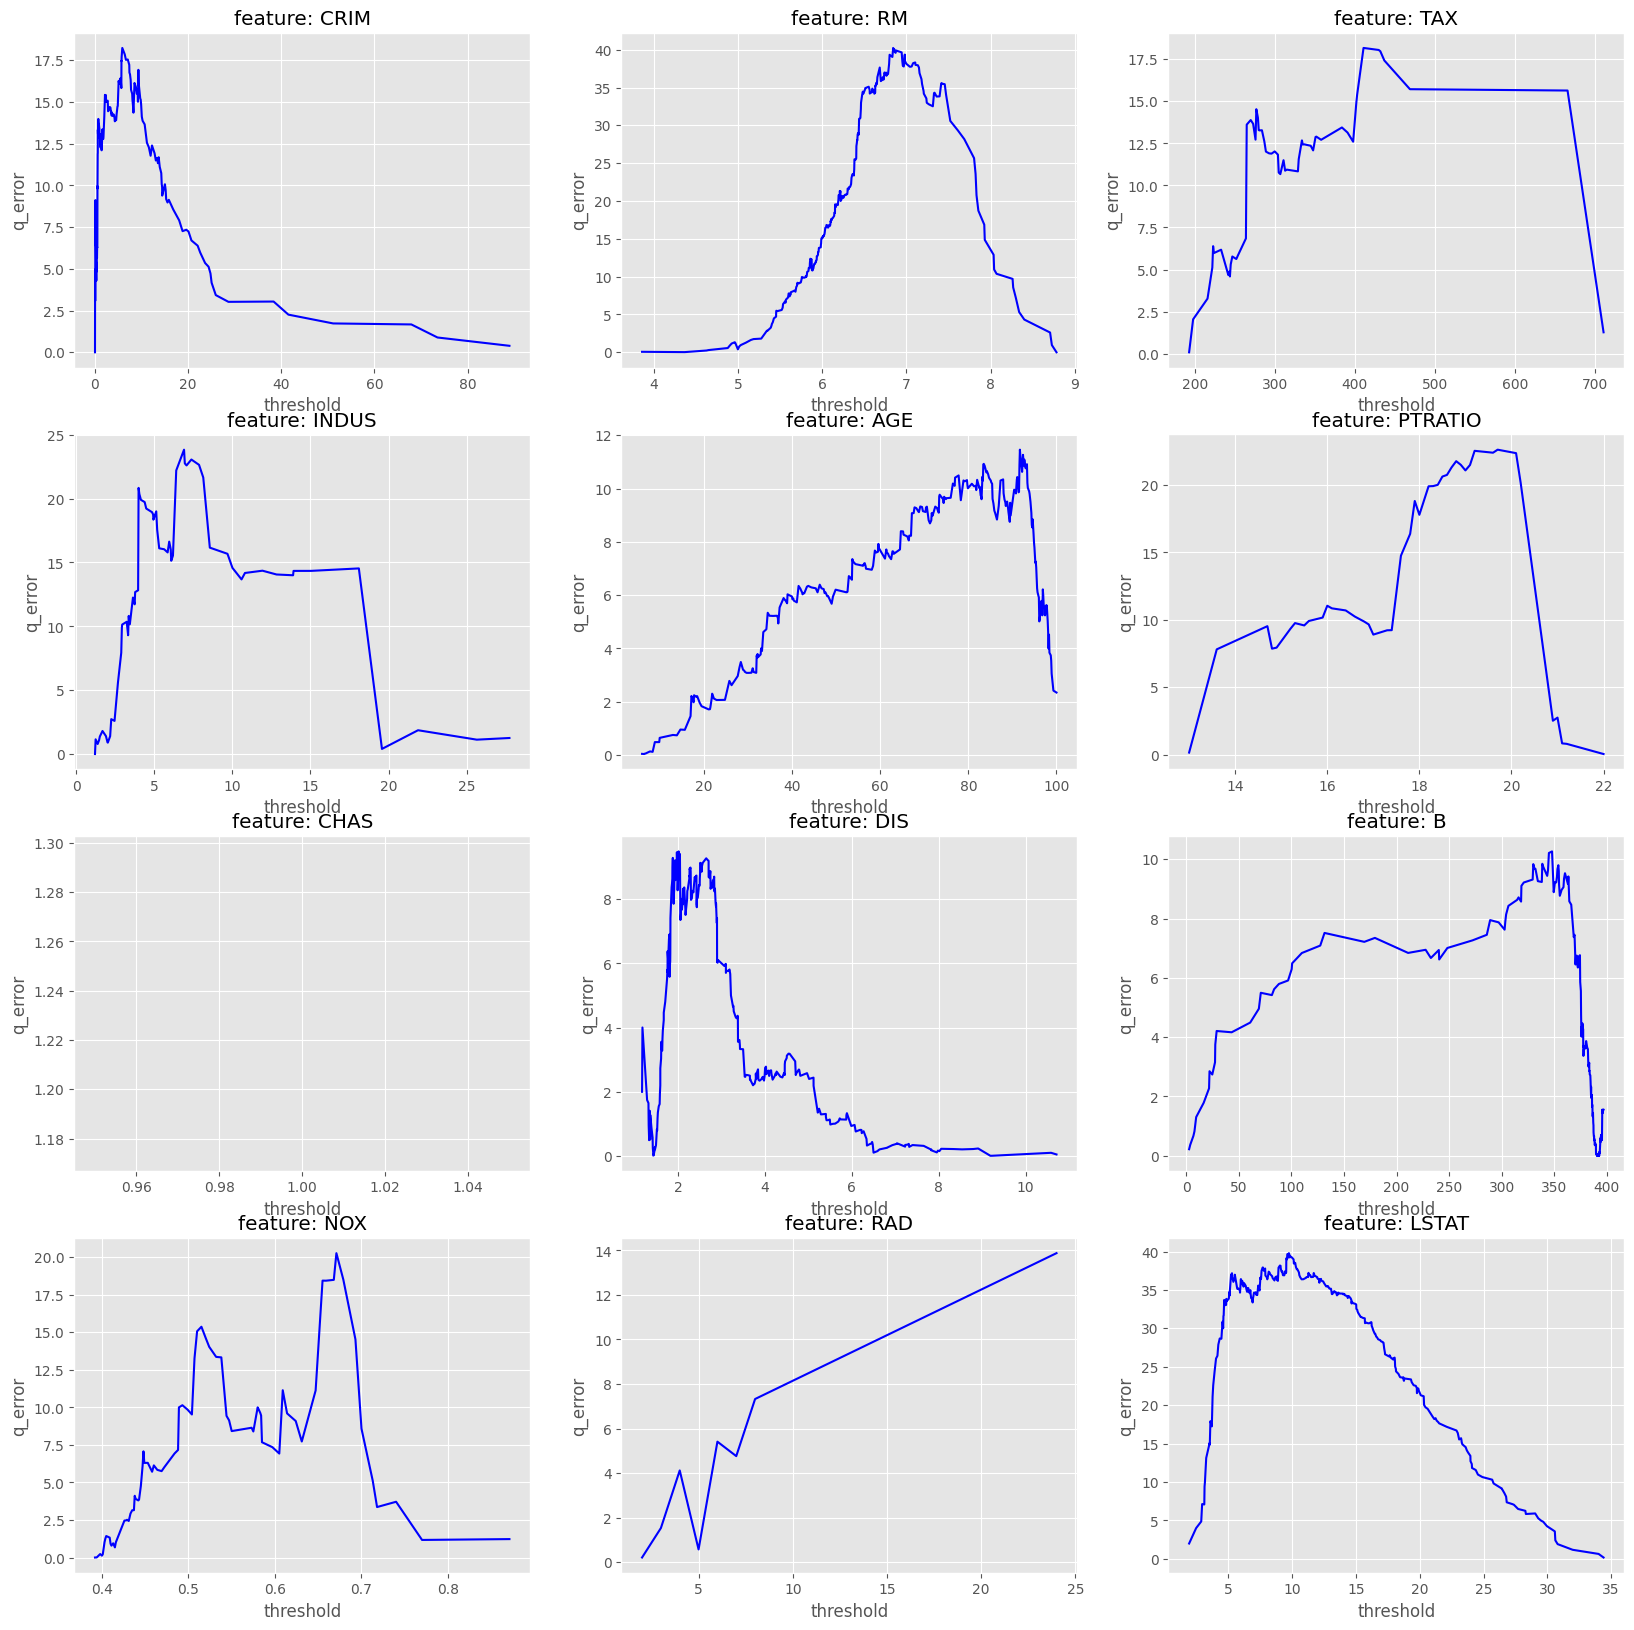

In [ ]:
fig, axis = plt.subplots(4,3,figsize = (20, 20));
rows_indices = np.tile([0, 1, 2, 3], 3)
for i,j in enumerate(rows_indices):
  col_index = i // 4
  feature = list(errors_data.keys())[i]
  #print(errors_data[feature].shape)
  axis[j, col_index].plot(errors_data[feature][:,1], errors_data[feature][:,0], color = 'blue')
  axis[j, col_index].set_title(f'feature: {feature}')
  axis[j, col_index].set_xlabel('threshold')
  axis[j, col_index].set_ylabel('q_error');

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [ ]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    is_first = True
    for element in R_m[feature]:
      error = q_error(R_m,feature, t = element)
      if is_first:
        if np.isnan(error):
          continue
        else:
          errors_thresholds = np.array([[error,element]], ndmin=2)
          is_first = False
      else:
        if np.isnan(error):
          continue
        else:
          errors_thresholds = np.append(errors_thresholds,[[error,element]], axis = 0)
    #print(errors_thresholds)
    min_index = np.argmin(errors_thresholds[:, 0])
    min_error = np.min(errors_thresholds[:, 0])
    optimal_split = errors_thresholds[min_index,1]

    return tuple([optimal_split, min_error])

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

оптимальный порог разбиения:392.52 критерий ошибки: 1.7120293129835318e-06 признак:B


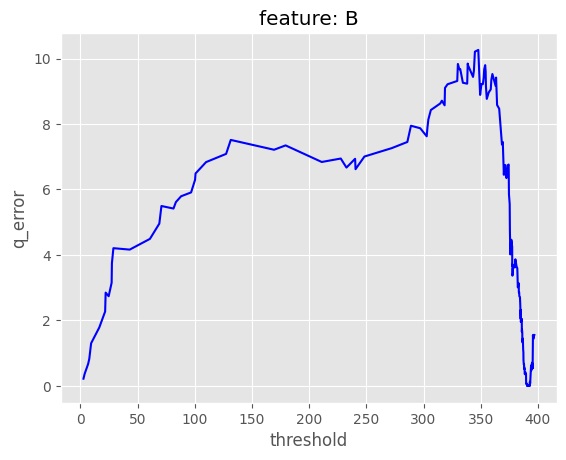

In [ ]:
optimal_threshold = 0
min_error = 1000
list_with_best_feature = [optimal_threshold,min_error,'']
for feature in features:
  is_first = True
  X_train = X_train.sort_values(feature)
  optimal_split = get_optimal_split(X_train, feature=feature)
  if optimal_split[1] < min_error:
    optimal_threshold = optimal_split[0]
    min_error = optimal_split[1]
    list_with_best_feature[0] = optimal_threshold
    list_with_best_feature[1] = min_error
    list_with_best_feature[2] = feature
    #print(optimal_split)
print(f"оптимальный порог разбиения:{list_with_best_feature[0]}",
      f"критерий ошибки: {list_with_best_feature[1]}",
      f"признак:{list_with_best_feature[2]}") # порог разбиения / критерий ошибки / признак
plt.plot(errors_data[list_with_best_feature[2]][:,1], errors_data[list_with_best_feature[2]][:,0], color = 'blue')
plt.title(f'feature: {list_with_best_feature[2]}')
plt.xlabel('threshold')
plt.ylabel('q_error');

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

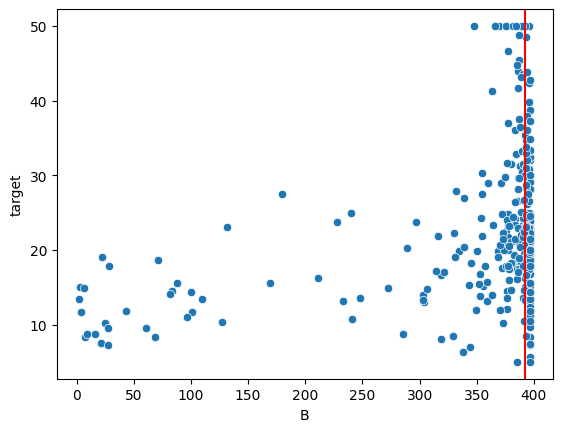

In [ ]:
threshold=list_with_best_feature[0]
plt.style.use('default')
ax = sns.scatterplot(x=list_with_best_feature[2],
                     y='target', data=X_train)#sns.color_palette("flare")

ax.axvline(x=threshold, color='r', linestyle='-');